In [47]:
import re
import string


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from tqdm import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Input, InputLayer, RNN, SimpleRNN, LSTM, GRU, TimeDistributed
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
df = pd.read_csv('News.csv')
df.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [49]:
df.shape

(2225, 4)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   filename  2225 non-null   object
 2   title     2225 non-null   object
 3   content   2225 non-null   object
dtypes: object(4)
memory usage: 69.7+ KB


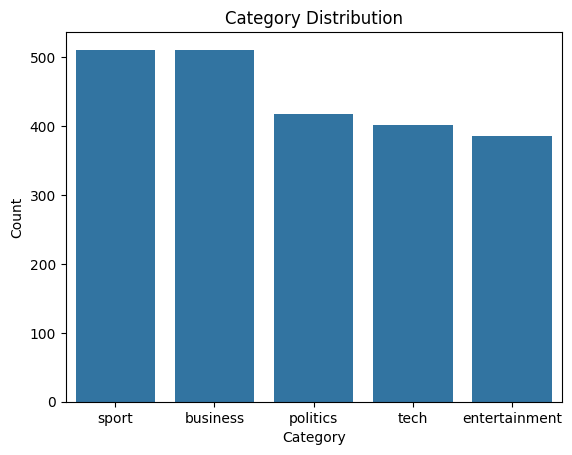

In [51]:
sns.barplot(x=df.category.value_counts().index, y=df.category.value_counts().values )
plt.title('Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

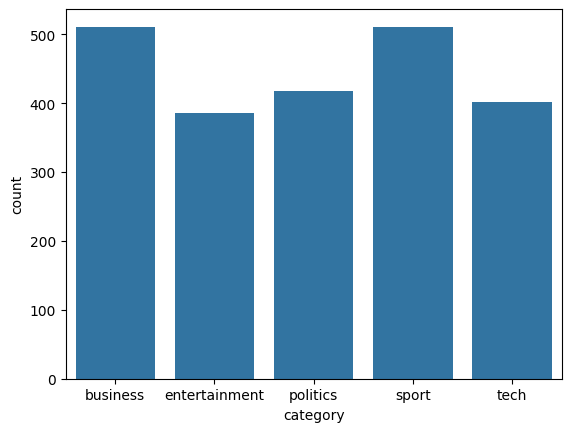

In [52]:
sns.countplot(x=df.category)
plt.show()

## Text Cleaning:-

In [53]:
def data_cleaning(text):

    cleaned = text.lower()
    cleaned = cleaned.replace(".", ". ")
    tokens = [word for word in cleaned.split() if not word in stop_words]
    tokens = [tok.translate(str.maketrans(' ', ' ', string.punctuation)) for tok in tokens]
    cleaned = " ".join(tokens)
    cleaned = cleaned.strip()

    return cleaned

In [54]:
for index, data in tqdm(df.iterrows(), total=df.shape[0]):
    df.loc[index, 'title'] = data_cleaning(data['title'])

100%|██████████| 2225/2225 [00:00<00:00, 6062.40it/s]


## Fixing the sequence length:-

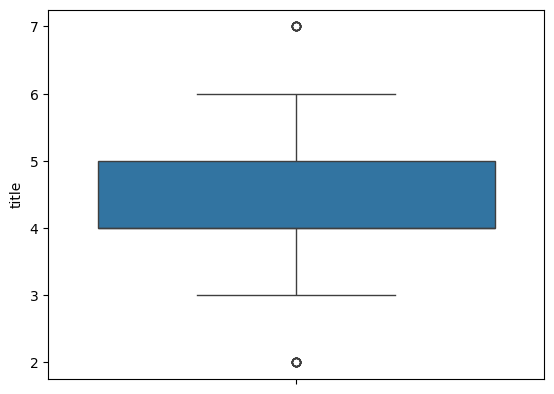

In [55]:
sns.boxplot(df['title'].str.split(" ").str.len())
plt.show()

In [56]:
max_sentences_len = df['title'].str.split(" ").str.len().max()
total_classes = df['category'].nunique()

print('Maximum sequence length : ', max_sentences_len)
print('Total classes :',total_classes )

Maximum sequence length :  7
Total classes : 5


## Splitting the dataset into train and test


In [57]:
np.random.seed(100)

train_X, test_X, train_Y, test_Y = train_test_split(df['title'], df['category'], test_size=0.2, random_state=100)

train_X = train_X.reset_index(drop=True)
test_X = test_X.reset_index(drop=True)
train_Y = train_Y.reset_index(drop=True)
train_Y = train_Y.reset_index(drop=True)



In [58]:
train_X.shape, train_Y.shape, test_X.shape, test_Y.shape

((1780,), (1780,), (445,), (445,))

## One hot encode the labels:-

In [59]:
train_Y = pd.get_dummies(train_Y).values
test_Y = pd.get_dummies(test_Y).values

In [60]:
validation = test_Y.argmax(axis=1)

In [61]:
def tokenize_and_pad(inp_text, max_len, tok):

    text_seq = tok.texts_to_sequences(inp_text)
    text_seq = pad_sequences(text_seq, maxlen=max_len, padding='post')

    return text_seq

text_tok = Tokenizer()
text_tok.fit_on_texts(train_X)
train_text_X = tokenize_and_pad(inp_text=train_X, max_len=max_sentences_len, tok=text_tok)
test_text_X = tokenize_and_pad(inp_text=test_X, max_len=max_sentences_len, tok=text_tok)
vocab_size = len(text_tok.word_index)+1

print('Overall text vocab size: ', vocab_size)


Overall text vocab size:  3360


## Choose the latent and embedding dimesion:-

In [62]:
latent_dim = 50
embedding_dim = 100

## Define a RNN model archietecture:-


In [63]:
seed=56
tf.random.set_seed(seed)
np.random.seed(seed)

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, trainable=True))
model.add(SimpleRNN(latent_dim, recurrent_dropout=0.2, return_sequences=False, activation='tanh'))
model.add(Dense(total_classes, activation='softmax'))
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Model Training:-

In [64]:
tf.random.set_seed(seed)
np.random.seed(seed)

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])

early_stopping = EarlyStopping(monitor='val_acc',
                               mode='max',
                               verbose=1,
                               patience=5)

model.fit(x=train_text_X, y=train_Y,
          validation_data=(test_text_X, test_Y),
          batch_size=64,
          epochs=10,
          callbacks=[early_stopping])

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - acc: 0.2428 - loss: 1.5979 - val_acc: 0.2876 - val_loss: 1.5566
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.5565 - loss: 1.3618 - val_acc: 0.5236 - val_loss: 1.2508
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.8042 - loss: 0.7543 - val_acc: 0.6539 - val_loss: 0.9317
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9253 - loss: 0.3130 - val_acc: 0.6764 - val_loss: 1.0135
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9757 - loss: 0.1300 - val_acc: 0.6876 - val_loss: 1.1319
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9822 - loss: 0.0858 - val_acc: 0.6764 - val_loss: 1.2801
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.9966 - loss: 0.0457 - val_acc: 0.6876 - val_loss: 1.3528
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.9937 - loss: 0.0401 - val_acc: 0.6742 - val_loss: 1.4422
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.9987 - 

## Save the model:-

In [65]:
model.save("BCC_classifier.keras")

## Load the model:-

In [66]:
model = tf.keras.models.load_model("BCC_classifier.keras")

## Make predictions on the test dataset

In [ ]:
prediction = model.predict(test_text_X)
prediction = prediction.argmax(axis=1)
print(f"Accuracy: {accuracy_score(prediction, validation)}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.6786516853932584
